<a href="https://colab.research.google.com/github/d2021101420/MonoDepth-PyTorch/blob/master/Mauricio_Monodepth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clone 
!git clone https://github.com/d2021101420/MonoDepth-PyTorch

Cloning into 'MonoDepth-PyTorch'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 205 (delta 5), reused 0 (delta 0), pack-reused 193
Receiving objects: 100% (205/205), 34.37 MiB | 24.63 MiB/s, done.
Resolving deltas: 100% (111/111), done.


In [2]:
%cd MonoDepth-PyTorch/

/content/MonoDepth-PyTorch


In [3]:
#Apagar dataset original
#!rm kitti_archives_to_download.txt
#Carregar arquivo com indice de datasets
#from google.colab import files
#files.upload()

In [4]:
!mkdir data
%cd data
!mkdir models
%cd models
!pwd

/content/MonoDepth-PyTorch/data
/content/MonoDepth-PyTorch/data/models
/content/MonoDepth-PyTorch/data/models


In [5]:
#Carregar modelo 


#!wget https://p-def6.pcloud.com/cBZcIboSHZMPuC9HZZZDTMLv7Z2ZZfLRZkZkCcA0ZskZE5ZqXZqHZ10Z5kZHZI7ZoFZ8VZS7ZwVZb0ZYXZb5r97Z8VQ93u4jwMpRRuv6zpzmoHFV8cIV/monodepth_resnet18_001.pth -P ~/data/models

import gdown
url='https://drive.google.com//uc?id=1n6_RqYurD8-EqY121uSyWZUwWHQX-mPG'
output='monodepth_resnet18_001.pth'
#time.sleep(100)
gdown.download(url, output, quiet=False)
#!gdown --id https://drive.google.com/file/d/1n6_RqYurD8-EqY121uSyWZUwWHQX-mPG
#from google.colab import files
#files.upload()

Downloading...
From: https://drive.google.com//uc?id=1n6_RqYurD8-EqY121uSyWZUwWHQX-mPG
To: /content/MonoDepth-PyTorch/data/models/monodepth_resnet18_001.pth
81.0MB [00:02, 28.9MB/s]


'monodepth_resnet18_001.pth'

In [6]:
!ls -l 

total 79132
-rw-r--r-- 1 root root 81027095 Jun 19 17:39 monodepth_resnet18_001.pth


In [7]:
%cd /content/MonoDepth-PyTorch/

/content/MonoDepth-PyTorch


## Train

Check if CUDA is available

In [8]:
import os
import torch
import numpy as np
import skimage.transform
import matplotlib.pyplot as plt
from easydict import EasyDict as edict

from main_monodepth_pytorch import Model
%reload_ext autoreload
%autoreload 2

In [9]:
torch.cuda.is_available()

True

In [10]:
torch.cuda.device_count()

1

In [11]:
torch.cuda.empty_cache()

IMPORTAÇÃO DOS DATASETs de Treinamento, Validação e testes

Dataset escolhido = Mid-Air, The Montefiore Institute Dataset of Aerial Images and Records

https://midair.ulg.ac.be/

When using this dataset in your research, we would appreciate that you cite our CVPRW paper:

@INPROCEEDINGS{Fonder2019MidAir,
author = {Michael Fonder and Marc Van Droogenbroeck},
title = {Mid-Air: A multi-modal dataset for extremely low altitude drone flights},
booktitle = {Conference on Computer Vision and Pattern Recognition Workshop (CVPRW)},
year = {2019},
month = {June}
}


In [12]:

from google.colab import drive
drive.mount('/content/drive/', force_remount=True)



Mounted at /content/drive/


In [13]:
!ls -l /content/drive/MyDrive/MIDAIR/train/color_right/

ls: cannot access '/content/drive/MyDrive/MIDAIR/train/color_right/': No such file or directory


In [14]:
#!wget --content-disposition -x -nH -i /content/drive/MyDrive/MIDAIR/download_config.txt -P /content/drive/MyDrive/MIDAIR

In [15]:
#%cd /content/drive/MyDrive/MIDAIR/train/color_left/

In [16]:
#!find  . -name "*.zip" | while read filename; do unzip -o -d $(dirname "$filename") "$filename"; done;

In [17]:
#%cd /content/drive/MyDrive/MIDAIR/train/color_left/
#!mkdir data

#!find . -name "*.JPEG" -exec mv -t /content/drive/MyDrive/MIDAIR/train/color_left/data {} +

In [18]:
#%cd /content/drive/MyDrive/MIDAIR/train/color_right/
#!mkdir data

#!find . -name "*.JPEG" -exec mv -t /content/drive/MyDrive/MIDAIR/train/color_right/data {} +

In [19]:
#%cd /content/drive/MyDrive/MIDAIR/val
#!find  . -name "*.zip" | while read filename; do unzip -o -d $(dirname "$filename") "$filename"; done;

In [20]:

#%cd /content/drive/MyDrive/MIDAIR/val/color_left/
#!mkdir data

#!find . -name "*.JPEG" -exec mv -t /content/drive/MyDrive/MIDAIR/val/color_left/data {} +

#%cd /content/drive/MyDrive/MIDAIR/val/color_right/
#!mkdir data

#!find . -name "*.JPEG" -exec mv -t /content/drive/MyDrive/MIDAIR/val/color_right/data {} +

In [21]:
#%cd /content/drive/MyDrive/MIDAIR/val
#!find  . -name "*.zip" | while read filename; do unzip -o -d $(dirname "$filename") "$filename"; done;


In [22]:
#%cd /content/drive/MyDrive/MIDAIR/train/
#!mkdir trajectory

#!find . -name "color*" -exec mv -t /content/drive/MyDrive/MIDAIR/train/trajectory {} +

#%cd /content/drive/MyDrive/MIDAIR/val/
#!mkdir trajectory

#!find . -name "color*" -exec mv -t /content/drive/MyDrive/MIDAIR/val/trajectory {} +



In [23]:
dict_parameters = edict({'data_dir':'/content/drive/MyDrive/MIDAIR/train/',
                         'val_data_dir':'/content/drive/MyDrive/MIDAIR/val/',
                         'model_path':'/content/MonoDepth-PyTorch/data/models/monodepth_resnet18_001.pth',
                         'output_directory':'/content/drive/MyDrive/MIDAIR/output/',
                         'input_height':256,
                         'input_width':512,
                         'model':'resnet18_md',
                         'pretrained':True,
                         'mode':'train',
                         'epochs':20, #200
                         'learning_rate':1e-4,
                         'batch_size': 2,  #8
                         'adjust_lr':True,
                         'device':'cuda:0',
                         'do_augmentation':True,
                         'augment_parameters':[0.8, 1.2, 0.5, 2.0, 0.8, 1.2],
                         'print_images':False,
                         'print_weights':False,
                         'input_channels': 3,
                         'num_workers': 8,
                         'use_multiple_gpu': False})

In [24]:
model = Model(dict_parameters)
model.load('/content/MonoDepth-PyTorch/data/models/monodepth_resnet18_001.pth')

Use a dataset with 2205 images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Use a dataset with 2206 images


In [25]:
model.train()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to

Val_loss: 1.4937668450565296
Epoch: 1 train_loss: 1.0808868402529066 val_loss: 1.6461289367437903 time: 308.17 s
Model_saved
Epoch: 2 train_loss: 1.0196900087005965 val_loss: 1.6653530988022853 time: 250.232 s
Epoch: 3 train_loss: 0.9959721935141227 val_loss: 1.7339708201739252 time: 249.708 s
Epoch: 4 train_loss: 0.9822833935644879 val_loss: 1.7460388047354563 time: 250.07 s
Epoch: 5 train_loss: 0.9713148606007248 val_loss: 1.7494482493454637 time: 249.451 s
Epoch: 6 train_loss: 0.9561625715963211 val_loss: 1.7475555322067537 time: 248.745 s
Epoch: 7 train_loss: 0.9496792727779066 val_loss: 1.7503295082083634 time: 248.782 s
Epoch: 8 train_loss: 0.9453837736860148 val_loss: 1.7783876989974456 time: 248.776 s
Epoch: 9 train_loss: 0.9285302347523022 val_loss: 1.771715941937332 time: 248.848 s
Epoch: 10 train_loss: 0.9441603162103853 val_loss: 1.7637917400758012 time: 249.287 s
Epoch: 11 train_loss: 0.9272441799977856 val_loss: 1.7950260048820859 time: 248.845 s
Epoch: 12 train_loss: 0.9

## Test the model

In [26]:
!ls /content/drive/MyDrive/MIDAIR/test/trajectory/color_left/data


 000000.JPEG	       000553.JPEG	     001106.JPEG	   001658.JPEG
 000001.JPEG	       000554.JPEG	     001107.JPEG	   001659.JPEG
 000002.JPEG	       000555.JPEG	     001108.JPEG	   001660.JPEG
 000003.JPEG	       000556.JPEG	     001109.JPEG	   001661.JPEG
 000004.JPEG	       000557.JPEG	     001110.JPEG	   001662.JPEG
 000005.JPEG	       000558.JPEG	     001111.JPEG	   001663.JPEG
 000006.JPEG	       000559.JPEG	     001112.JPEG	   001664.JPEG
 000007.JPEG	       000560.JPEG	     001113.JPEG	   001665.JPEG
 000008.JPEG	       000561.JPEG	     001114.JPEG	   001666.JPEG
 000009.JPEG	       000562.JPEG	     001115.JPEG	   001667.JPEG
 000010.JPEG	       000563.JPEG	     001116.JPEG	   001668.JPEG
 000011.JPEG	       000564.JPEG	     001117.JPEG	   001669.JPEG
 000012.JPEG	       000565.JPEG	     001118.JPEG	   001670.JPEG
 000013.JPEG	       000566.JPEG	     001119.JPEG	   001671.JPEG
 000014.JPEG	       000567.JPEG	     001120.JPEG	   001672.JPEG
 000015.JPEG	       000568.JPEG	     001

In [27]:
#!wget --content-disposition -x -nH -i /content/drive/MyDrive/MIDAIR/test/download_config.txt -P /content/drive/MyDrive/MIDAIR/test

In [28]:
#%cd /content/drive/MyDrive/MIDAIR/test
#!find  . -name "*.zip" | while read filename; do unzip -o -d $(dirname "$filename") "$filename"; done;

In [29]:
#%cd /content/drive/MyDrive/MIDAIR/test/
#!mkdir trajectory

#!find . -name "color*" -exec mv -t /content/drive/MyDrive/MIDAIR/test/trajectory {} +

In [30]:
#%cd /content/drive/MyDrive/MIDAIR/test/trajectory/color_left/
#!mkdir data

#!find . -name "*.JPEG" -exec mv -t /content/drive/MyDrive/MIDAIR/test/trajectory/color_left/data {} +

#%cd /content/drive/MyDrive/MIDAIR/test/trajectory/color_right/
#!mkdir data

#!find . -name "*.JPEG" -exec mv -t /content/drive/MyDrive/MIDAIR/test/trajectory/color_right/data {} +

In [31]:
!ls /content/drive/MyDrive/MIDAIR/test

trajectory


In [32]:
dict_parameters_test = edict({'data_dir':'/content/drive/MyDrive/MIDAIR/test',
                              'model_path':'/content/MonoDepth-PyTorch/data/models/monodepth_resnet18_001_cpt.pth',
                              'output_directory':'/content/drive/MyDrive/MIDAIR/output',
                              'input_height':256,
                              'input_width':512,
                              'model':'resnet18_md',
                              'pretrained':False,
                              'mode':'test',
                              'device':'cuda:0',
                              'input_channels':3,
                              'num_workers':4,
                              'use_multiple_gpu':False})
model_test = Model(dict_parameters_test)

Use a dataset with 2215 images


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [33]:
model_test.test()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finished Testing


In [34]:
disp = np.load('/content/drive/MyDrive/MIDAIR/output/disparities.npy')  # Or disparities.npy for output without post-processing
disp.shape

(2215, 256, 512)

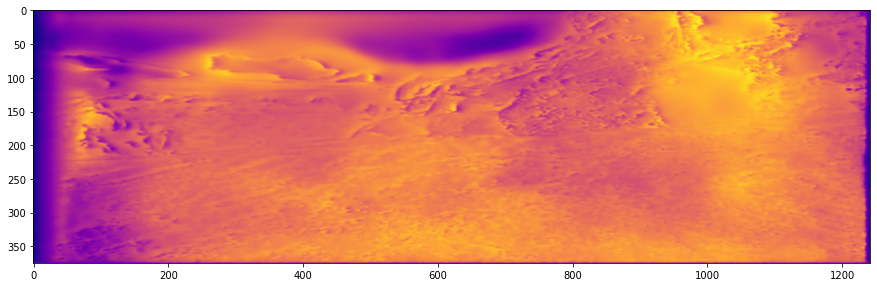

In [35]:
disp_to_img = skimage.transform.resize(disp[0].squeeze(), [375, 1242], mode='constant')
plt.imshow(disp_to_img, cmap='plasma')

Save a color image

In [36]:
plt.imsave(os.path.join(dict_parameters_test.output_directory,
                        dict_parameters_test.model_path.split('/')[-1][:-4]+'_test_output.png'), disp_to_img, cmap='plasma')

Save all test images

In [37]:
for i in range(disp.shape[0]):
    disp_to_img = skimage.transform.resize(disp[i].squeeze(), [375, 1242], mode='constant')
    plt.imsave(os.path.join(dict_parameters_test.output_directory,
               'pred_'+str(i)+'.png'), disp_to_img, cmap='plasma')

Save a grayscale image

In [38]:
plt.imsave(os.path.join(dict_parameters_test.output_directory,
                        dict_parameters_test.model_path.split('/')[-1][:-4]+'_gray.png'), disp_to_img, cmap='gray')

In [ ]:
!zip -r /content/drive/MyDrive/MIDAIR/monodepth-output-maa.zip /content/drive/MyDrive/MIDAIR/output/
